# Baseline решение от команды mipt dudes

## Библиотеки и таблица с данными

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt

In [19]:
df = pd.read_pickle('data_not_clean.pkl')
df

,query,text,label,clean_text,clean_query,embedding_text,embedding_query
0,Когда был спущен на воду первый миноносец «Спо...,Зачислен в списки ВМФ СССР 19 августа 1952 год...,1,Зачислен в списки ВМФ СССР 19 августа 1952 год...,Когда был спущен на воду первый миноносец «Спо...,"[-0.0030975677, -0.018142669, -0.0058722952, 0...","[0.00064380514, 0.0074218363, -0.03353223, -0...."
1,Как долго существовало британское телевизионно...,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",1,"Хрустальный лабиринт (""The Crystal Maze"") — бр...",Как долго существовало британское телевизионно...,"[0.0026477594, -0.026646728, 0.0009579654, -0....","[-0.029795218, -0.01173853, -0.00032150946, -0..."
2,Когда родилась Князева Марина Леонидовна?,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,1,Князева Марина Леонидовна (род. 7 мая 1952 г.)...,Когда родилась Князева Марина Леонидовна?,"[-0.036747612, -0.012604811, -0.0109199695, -0...","[-0.036575466, -0.010551005, -0.04117768, -0.0..."
3,Кто был главным художником мира Зен?,"В книге ""Half-Life 2: Raising the Bar"" художни...",1,"В книге ""Half-Life 2: Raising the Bar"" художни...",Кто был главным художником мира Зен?,"[-0.02514373, -0.023727695, -0.04738828, 0.011...","[-0.022960061, -0.013048667, -0.018877652, -0...."
4,Как звали предполагаемого убийцу Джона Кеннеди?,В 1966 году окружной прокурор Нового Орлеана Д...,1,В 1966 году окружной прокурор Нового Орлеана Д...,Как звали предполагаемого убийцу Джона Кеннеди?,"[0.0074619167, -0.024880972, -0.026498705, 0.0...","[-0.0124044325, -0.0020067864, -0.030558525, 0..."
...,...,...,...,...,...,...,...
47016,Кто убил Зорана Джинджича?,Смерть Зорана Джинджича была констатирована в ...,0,Смерть Зорана Джинджича была констатирована в ...,Кто убил Зорана Джинджича?,"[-0.008258977, 0.0024080626, -0.04842605, -0.0...","[-0.052019194, 0.01754323, -0.05360399, -0.031..."
47017,Кто убил Зорана Джинджича?,"Аресты по делу Джинджича, однако, продолжились...",0,"Аресты по делу Джинджича, однако, продолжились...",Кто убил Зорана Джинджича?,"[0.008173082, 0.052790318, -0.05316838, 0.0171...","[-0.052019194, 0.01754323, -0.05360399, -0.031..."
47018,Кто убил Зорана Джинджича?,Ратомир Живкович обвинил в организации убийств...,0,Ратомир Живкович обвинил в организации убийств...,Кто убил Зорана Джинджича?,"[-0.017322723, 0.013281805, -0.039236594, -0.0...","[-0.052019194, 0.01754323, -0.05360399, -0.031..."
47019,Кто убил Зорана Джинджича?,В 12:25 (по свидетельству Биляны Станков и вод...,0,В 12:25 (по свидетельству Биляны Станков и вод...,Кто убил Зорана Джинджича?,"[-0.024740426, -0.006180703, -0.046707638, 0.0...","[-0.052019194, 0.01754323, -0.05360399, -0.031..."


## Метрика 

Интуиция - предполагается что будет дальнейшая обработка результата, так что нам важно хорошо попадать в первые топ N ответов. При этом хочется чтобы все правильные ответы шли выше чем неправильные.  

Пусть n - этого всего ответов на запрос, из них k - правильных.  

Метрика это процент правильных ответов, которые находятся среди первых max(3, k) позиций после ранжирования  

_чуть позднее мы узнали что придумали presign@k, но модифицированный под нашу задачу. в целом после анализа множества сущестующих метрик пришли к выводу, что наша неожиданно хорошо подходит под задачу и данные, так что не стоит заменять. Единственный минус - метрика не учитывает уверенность модели в ответе, чтобы добавить это придумано улучшение - оно ниже в блоке метрики после результатов_


In [3]:
def custom_metric(df_sorted):
    # n - общее количество ответов, k - количество правильных ответов
    n = len(df_sorted)
    k = df_sorted['label'].sum()
    if k == 0:
        return 1
    # Количество позиций для оценки
    top_k = max(3, int(k))
    
    # Отбираем первые top_k ответов после ранжирования
    top_k_answers = df_sorted.iloc[:top_k]
    
    # Считаем количество правильных ответов среди первых top_k
    correct_in_top_k = top_k_answers['label'].sum()
    
    # Рассчитываем процент правильных ответов среди первых top_k
    score = correct_in_top_k / k
    
    return score


## Ранжирование

Ранжирование основано на косинусное мере близости эмбеддингов предложений.  

Мы просто берём эмбеддинги из предобученной модели и считаем косинусное расстояние от эмбеддинга вопроса к эмбеддингу ответа.  

Далее делаем софтмакс по всем ответам к конкретному запросу и добавляем полученные вероятности в таблицу.  

Возвращаем отсортированную==отранжированную таблицу.

In [4]:
def rank_answers(df):
    similarities = []
    for answer, query in zip(df['embedding_text'], df['embedding_query']):
        if not isinstance(answer, torch.Tensor):
            answer = torch.tensor(answer, dtype=torch.float32)
        if not isinstance(query, torch.Tensor):
            query = torch.tensor(query, dtype=torch.float32)
        if answer.shape != query.shape:
            raise ValueError("Размерности answer и query не совпадают.")
        
        similarity = torch.cosine_similarity(answer, query, dim=0).item()
        similarities.append(similarity)
    
    
    similarities_tensor = torch.tensor(similarities)
    similarities_softmax = F.softmax(similarities_tensor, dim=0).numpy()
    
    df_copy = df.copy()
    df_copy['similarity'] = similarities_softmax
    
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    return df_sorted

## Эксперимент

In [20]:
res = []
#i=0
for quey, text in df.groupby('query'):
    #i+=1
    x = rank_answers(text)
    score = custom_metric(x)
    n = len(x)
    k = x['label'].sum()
    res.append([quey,score, n, k])
    print(quey, 'score =',score,'N =',n, 'K =', k)
    #if i ==6:
    #    break

456 — инопланетная раса- это раса из какого фильма? score = 1.0 N = 11 K = 1
AKB48 выступала в России? score = 1.0 N = 1 K = 1
BBC частная или государственная компания? score = 1.0 N = 1 K = 1
Daewoo Lanos собирали на Украине? score = 1.0 N = 1 K = 1
Higurashi no Naku Koro ni стала любительской игрой в Японии? score = 1.0 N = 14 K = 1
Joy Division распалась? score = 0.75 N = 10 K = 4
M16 выпускается в США на март 2019? score = 1.0 N = 1 K = 1
M3 поставлялся на экспорт? score = 0.75 N = 10 K = 8
Queen посещала Россию? score = 1.0 N = 1 K = 1
Sex Pistols была скандальной группой? score = 1.0 N = 10 K = 8
«Агенты "Щ.И.Т."» - это драматический сериал? score = 1.0 N = 11 K = 2
«Двадцать восемь панфиловцев» стал лучшим фильмом России 2016 года? score = 1.0 N = 10 K = 2
«Джойнт» была отмечена премией государства Израиль? score = 1.0 N = 10 K = 2
«Ислáмское госудáрство»- террористическая организация? score = 0.75 N = 10 K = 4
«Лос-Анджелес Лейкерс» был чемпионом НБА? score = 0.8888888888888888

In [14]:
len(res)

5935

In [21]:
summ_score = 0
summ_N = 0
summ_k = 0
for elem in res:
    summ_score += elem[1]
    summ_N += elem[2]
    summ_k += elem[3]
print(summ_score/len(res),summ_N/len(res),summ_k/len(res) )

0.8247479306240898 7.920640269587195 2.2845829823083403


#### Раньше было 0.58 на эмбеддингах из rubert-tiny, и 0.74 на предобработанных данных и новых эмбеддингах, в этой итерации мы сделали максимально качественную предобработку и самые крутые эмбеддинги, описали в презентации

**В среднем 8 ответом, из них 2.3 правильных, мы находим их в топ 3 не хуже чем с вероятностью 82%, что замечательно**

In [17]:
from collections import defaultdict

res_dict_N = defaultdict(float)
res_dict_N_count = defaultdict(int)
res_dict_k = defaultdict(float)
res_dict_k_count = defaultdict(int)

for elem in res:
    res_dict_N[elem[2]] += elem[1]
    res_dict_N_count[elem[2]] += 1
    res_dict_k[elem[3]] += elem[1]
    res_dict_k_count[elem[3]] += 1
list_for_N = []
for key, value in res_dict_N.items():
    list_for_N.append([key, value/res_dict_N_count[key]])

print(sorted(list_for_N))
print('----------')
list_for_k = []
for key, value in res_dict_k.items():
    list_for_k.append([key, value/res_dict_k_count[key]])
    
print(sorted(list_for_N))

[[1, 1.0], [2, 1.0], [3, 1.0], [4, 1.0], [5, 0.824074074074074], [8, 1.0], [9, 0.8211538461538462], [10, 0.8079545527131039], [11, 0.69614180213878], [12, 0.6575793650793651], [13, 0.5794290834613416], [14, 0.7583333333333333], [15, 0.5714285714285714], [16, 0.4444444444444444], [17, 0.6166666666666666], [18, 0.7777777777777778], [19, 0.75]]
----------
[[1, 1.0], [2, 1.0], [3, 1.0], [4, 1.0], [5, 0.824074074074074], [8, 1.0], [9, 0.8211538461538462], [10, 0.8079545527131039], [11, 0.69614180213878], [12, 0.6575793650793651], [13, 0.5794290834613416], [14, 0.7583333333333333], [15, 0.5714285714285714], [16, 0.4444444444444444], [17, 0.6166666666666666], [18, 0.7777777777777778], [19, 0.75]]


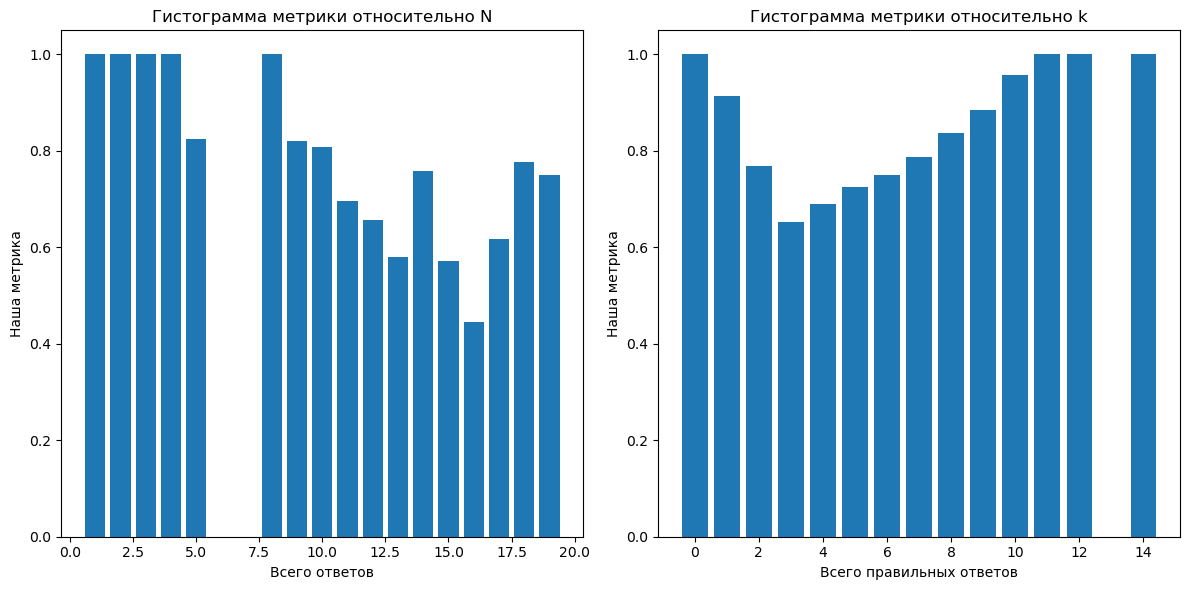

In [18]:
# Разделяем списки на отдельные списки для координат x и y
N_x = [x[0] for x in list_for_N]
N_y = [x[1] for x in list_for_N]

k_x = [x[0] for x in list_for_k]
k_y = [x[1] for x in list_for_k]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(N_x, N_y)
plt.xlabel('Всего ответов')
plt.ylabel('Наша метрика')
plt.title('Гистограмма метрики относительно N')

plt.subplot(1, 2, 2)
plt.bar(k_x, k_y)
plt.xlabel('Всего правильных ответов')
plt.ylabel('Наша метрика')
plt.title('Гистограмма метрики относительно k')

plt.tight_layout()
plt.show()

## Анализ результатов:
  - Разработали решение и метрику оценки результата
  - Провели эксперимент
    - Результаты нормальные, но проблемы когда мало правильных ответов или много всего вариантов. Но всё же сильно лучше случайного гадания
    - Вопросы к эмбеддингам, так как тексты специфичны и содержат много ньюансов. Как пример - наличие букв с указанными ударениями. Такие буквы неправильно воспринимаются моделью эмбеддингов, из-за чего искажается результирующий вектор.
  - Как итог план улучшений:
    - Исследование новых эмбеддингов
    - Предобработка текста
    - Улучшение модели, применение других вариантов решений

## Разные метрики 

In [10]:
def metric_with_weight(df_sorted):
    n = len(df_sorted)
    k = df_sorted['label'].sum()

    if k == 0:
        return 1
    
    # Количество позиций для оценки
    top_k = max(3, int(k))

    # Отбираем первые top_k ответов после ранжирования
    top_k_answers = df_sorted.iloc[:top_k]
    
    # Считаем количество правильных ответов среди первых top_k
    correct_in_top_k = top_k_answers['label'].sum()

    # Рассчитываем процент правильных ответов среди первых top_k
    base_score = correct_in_top_k / k

    # Уверенность модели - добавляем веса на основе отклонения similarity от среднего
    avg_similarity = df_sorted['similarity'].mean()
    similarity_deviation = abs(df_sorted['similarity'] - avg_similarity)

    # Присваиваем вес каждому ответу: чем больше отклонение от среднего, тем больше вес
    weights = 1 + similarity_deviation / avg_similarity

    # Применяем веса к правильным ответам в первых top_k позициях
    weighted_correct_in_top_k = (top_k_answers['label'] * weights[:top_k]).sum()

    # Рассчитываем итоговый score с учетом весов
    weighted_score = weighted_correct_in_top_k / k

    return weighted_score


In [16]:
res3 = []
i=0
for quey, text in df.groupby('query'):
    #i+=1
    x = rank_answers(text)
    n = len(x)
    if x['similarity'].iloc[0]-x['similarity'].iloc[n-1] > x['similarity'].iloc[0]*0.3:
        i+=1
        #print(x)
    score = metric_with_weight(x)
    n = len(x)
    k = x['label'].sum()
    res3.append([quey,score, n, k])
summ_score3 = 0

for elem in res3:
    summ_score3 += elem[1]

print(summ_score3/len(res3), i)

0.8857042301873578 283


#### Если учитывать уверенность модели в ответе, то метрика возрастает до 89%! 
Так как наша модель решает лишь промежуточную ступень задачи и возвращает топ 3 варианта с уверенностью для них - это волшебный результат.

#### Метрика показывающая индекс первого правильного ответа также не очень релевантна, так как есть данные на которых всего один ответ и он правильный, либо просто много правильных ответов и мало неправльных
В итоге по ней имеем 1.5, то есть правильный ответ в среднем есть среди первых двух. Что не позволяет сравнивать между собой модели. (на других итерациях с другими эмбеддингами был результат примерно такой же (было +-1.9))

In [22]:
def metric_first_true(df_sorted):
    n = len(df_sorted)
    k = df_sorted['label'].sum()

    if k == 0:
        return 1
    for i in range(n):
        if df_sorted['label'][i]==1:
            return i+1


In [23]:
res3 = []

for quey, text in df.groupby('query'):
    x = rank_answers(text)
    n = len(x)
    score = metric_first_true(x)
    n = len(x)
    k = x['label'].sum()
    res3.append([quey,score, n, k])
summ_score3 = 0

for elem in res3:
    summ_score3 += elem[1]

print(summ_score3/len(res3))

1.4729570345408594
